In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

In [7]:
# Caricamento degli oggetti addestrati
imp = joblib.load("pickles/imputer.pkl")
scaler = joblib.load("pickles/scaler.pkl")
bestclf = joblib.load("pickles/model.pkl")

categorical = ['F1','F3','F5','F6','F7','F8','F9','F13']
onehot_encoders = []
for i in range(len(categorical)):
    onehot_encoders.append(joblib.load(f"pickles/ohenc-ohe{i}.pkl"))

In [9]:
# Lettura test set
test = pd.read_csv("test_set.csv", sep = ",")

In [10]:
# Feature aggregation: i Paesi sono stati raggruppati per continenti
asia = ["Philippines", "India", "South", "China", "Vietnam", "Japan", "Taiwan", "Iran", "Thailand", "Cambodia", "Laos", "Hong"]
europe = ["Germany", "England", "Italy", "Poland", "Portugal", "Greece", "France", "Ireland", "Yugoslavia", "Hungary", "Scotland", "Netherlands"]
north_america = ["USA", "Canada"]
central_america = ["Mexico", "Puerto-Rico", "El-Salvador", "Cuba", "Jamaica", "Dominican-Republic", "Guatemala", "Haiti", "Nicaragua", "Caribbean", "Honduras"]
south_america = ["Columbia", "Peru", "Ecuador"]

for i in range(len(test)):
    if test.loc[i, "F13"] in asia:
        test.F13.replace(test.loc[i, "F13"], "asia", inplace = True)
    elif test.loc[i, "F13"] in europe:
        test.F13.replace(test.loc[i, "F13"], "europe", inplace = True)
    elif test.loc[i, "F13"] in north_america:
        test.F13.replace(test.loc[i, "F13"], "north_america", inplace = True)
    elif test.loc[i, "F13"] in central_america:
        test.F13.replace(test.loc[i, "F13"], "central_america", inplace = True)
    elif test.loc[i, "F13"] in south_america:
        test.F13.replace(test.loc[i, "F13"], "south_america", inplace = True)       

In [11]:
# Colonne feature categoriche
colF1 = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8']
colF3 = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16']
colF5 = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']
colF6 = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14']
colF7 = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
colF8 = ['caucasian', 'black', 'asian', 'american', 'other']
colF9 = ['Male', 'Female']
colF13 = ['asia', 'europe', 'north_america', 'central_america', 'south_america']

# Codifica delle feature categoriche
test.F1.replace(colF1, [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
test.F3.replace(colF3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], inplace = True)
test.F5.replace(colF5, [0, 1, 2, 3, 4, 5, 6], inplace = True)
test.F6.replace(colF6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], inplace = True)
test.F7.replace(colF7, [0, 1, 2, 3, 4, 5], inplace = True)
test.F8.replace(colF8, [0, 1, 2, 3, 4], inplace = True)
test.F9.replace(colF9, [0, 1], inplace = True)
test.F13.replace(colF13, [0, 1, 2, 3, 4], inplace = True)

In [12]:
# Suddivisione tra feature e target
x_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values
print(x_test.shape)
print(y_test.shape)

(4008, 14)
(4008,)


In [13]:
# Imputazione dei valori NaN tramite SimpleImputer, con la strategia che sostituisce i valori mancanti con la moda dei valori della feature
# Si utilizza l'oggetto caricato dal train
x_test_notnan = imp.transform(x_test)

In [14]:
# Creazione DataFrame da insiemi di test dopo l'imputazione dei valori mancanti 
colF = ['F0','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13']

test_set_df = pd.DataFrame(x_test_notnan, columns = colF)

In [20]:
# Codifica OneHot: i valori delle feature categoriche vengono codificati secondo la tecnica OneHot
# Si sfruttano gli oggetti Encoder addestrati in train e si invoca solo il metodo transform
onehot_df = pd.DataFrame()
columns = [colF1, colF3, colF5, colF6, colF7, colF8, colF9, colF13]
categorical_df = pd.DataFrame()

for i in categorical:
    categorical_df = pd.concat([categorical_df, test_set_df[i]], axis = 1)

j = 0

# Creazione del dataframe con le colonne codificate
for i in categorical:
    # one hot encoding della colonna i
    temp = pd.DataFrame(categorical_df[i].values)
    transformed = onehot_encoders[j].transform(temp)

    transformed_df = pd.DataFrame(transformed.toarray(), columns = columns[j], index = temp.index)

    onehot_df = pd.concat([onehot_df, transformed_df], axis = 1)
    j += 1

onehot_df.head(10)

array([0.])

In [21]:
# Unione con il DataFrame di partenza
test_set_df_oh = pd.concat([test_set_df, onehot_df], axis = 1)
test_set_df_oh = test_set_df_oh.drop(categorical, axis = 1)

test_set_df_oh.head(10)

In [ ]:
# Ricavo x_train da questo DataFrame
x_test_notnan = test_set_df_oh.values
print(x_test_notnan.shape)

In [25]:
# Scaling sfruttando l'oggetto caricato da train
x_test_scaled = scaler.transform(x_test_notnan)

In [26]:
# Predizione sul test set, con il classificatore caricato da train
y_pred = bestclf.predict(x_test_scaled)

0.8972055888223552


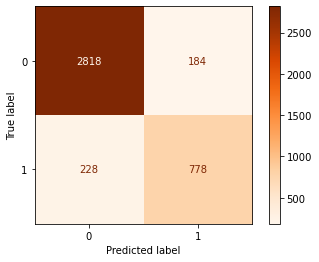

In [27]:
# Visualizzazione risultati sul test set (accuratezza)
CM_ADA = confusion_matrix(y_test, y_pred)
PercADA = (CM_ADA[0,0] + CM_ADA[1,1])/CM_ADA.sum()

cmd = ConfusionMatrixDisplay(CM_ADA)
cmd.plot(cmap = "Oranges")

print(PercADA)